
# TP4 — Fourier Transform & Filtering

**Auteur :** Loann KAIKA  


In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

base_dir = Path("C:/Users/loann/Desktop/cv2/Images")
if not base_dir.exists():
    base_dir = Path("./Images")

def show_gray(img, title=""):
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

def hist_gray(img, title="Histogramme"):
    plt.hist(img.ravel(), bins=256, range=(0,256))
    plt.title(title)
    plt.show()

def variance_of_laplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def load_gray(filename):
    path = base_dir/filename
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = np.full((256,256), 128, np.uint8)
        cv2.circle(img, (128,128), 60, 200, -1)
        print(f"[WARN] fallback synthétique pour {filename}")
    return img

def load_color(filename):
    path = base_dir/filename
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        img = np.zeros((256,256,3), np.uint8)
        img[:,:,1] = 180
        print(f"[WARN] fallback synthétique couleur pour {filename}")
    return img



## 1) FFT 2D et visualisation du module

On calcule la **FFT 2D** de l’image et on affiche le **log-magnitude** du spectre recentré.

- **Ce que renvoie la FFT 2D.**  

- **Pourquoi le log-magnitude (`log(1+|F|)`).**  
  On compresse la grande dynamique du module pour mieux voir les détails.

- **Rôle de `fftshift`.**  
  On **recentre** la composante DC : les **basses fréquences** au **centre**, les **hautes** vers les **coins**.

- **Remarque taille.**  
  Par défaut, la sortie a la **même taille** que l’entrée ; on peut modifier l’échantillonnage fréquentiel via **zero-padding** avant la FFT.


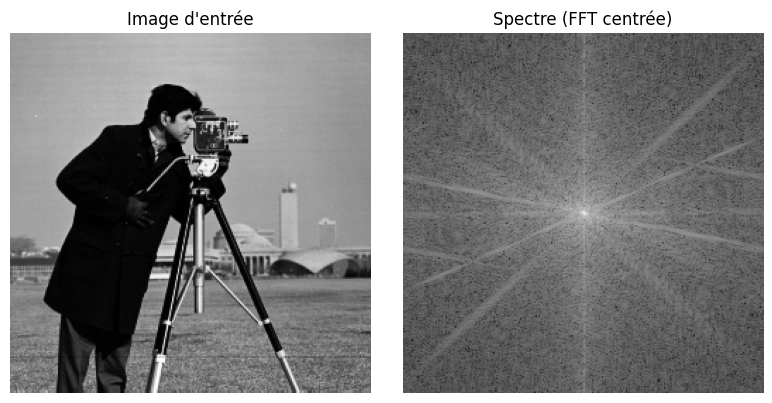

In [48]:
img = load_gray("cameraman.bmp")
F = np.fft.fft2(img)
Fshift = np.fft.fftshift(F)

magnitude = np.abs(Fshift)
log_mag = np.log1p(magnitude)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Image d'entrée")
axs[0].axis("off")

axs[1].imshow(log_mag, cmap="gray")
axs[1].set_title("Spectre (FFT centrée)")
axs[1].axis("off")

plt.tight_layout()
plt.show()



## 2) Exploration du spectre (module de la FFT)

On affiche, pour chaque image, l’image d’origine et le **log-magnitude du spectre** centré (`log(1+|FFT|)` avec `fftshift`).

**Pourquoi le log-magnitude ?**  
La dynamique du module de la FFT est très étendue : on compresse avec `log(1+|F|)` pour mieux voir à la fois le centre (basses fréquences) et les détails (hautes).

**Ce qu’on observe selon les images :**  
- Les **textures périodiques** (motifs, damiers) donnent des **pics discrets** dans le spectre.  
- Les **bords/contours orientés** créent des **structures allongées** perpendiculaires à l’orientation des bords.  
- Les images “douces” concentrent l’énergie **au centre** (basses fréquences dominantes).

**Rotation et spectre :**  
Quand on **fait tourner l’image**, le spectre **tourne du même angle**.

**Composante DC et moyenne :**  
`F[0,0]` (sans `fftshift`) est la **somme des intensités**.  
On a donc `moyenne ≈ Re(F[0,0]) / (H*W)`.

**Symétrie utile :**  
Pour une image réelle, le spectre est **conjugué symétrique** ; d’où des motifs en paires opposées.


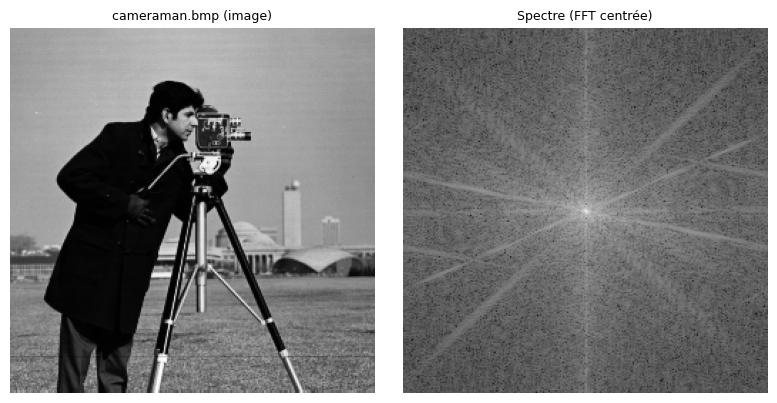

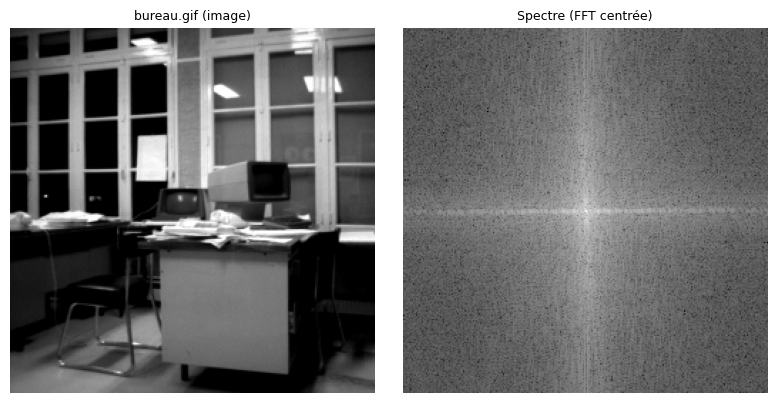

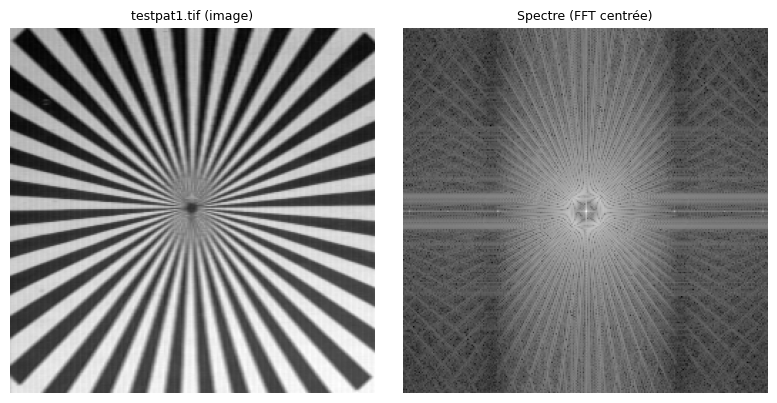

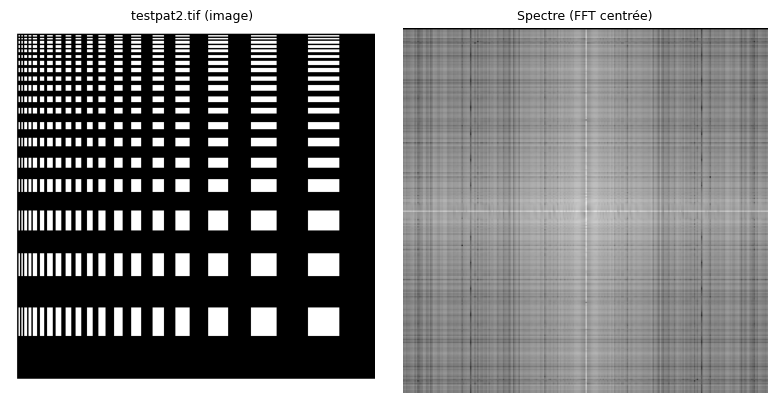

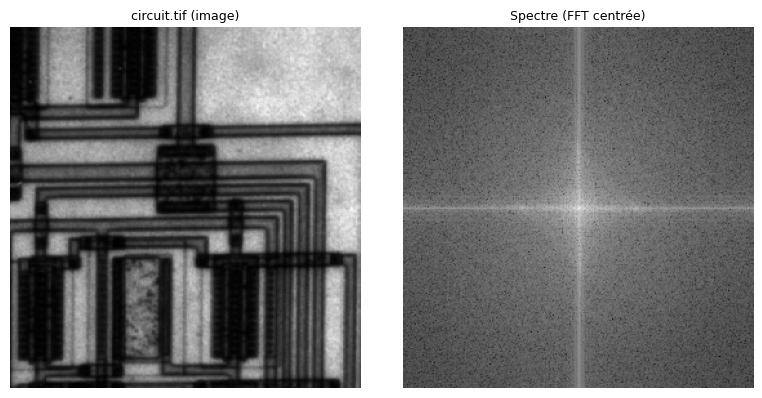

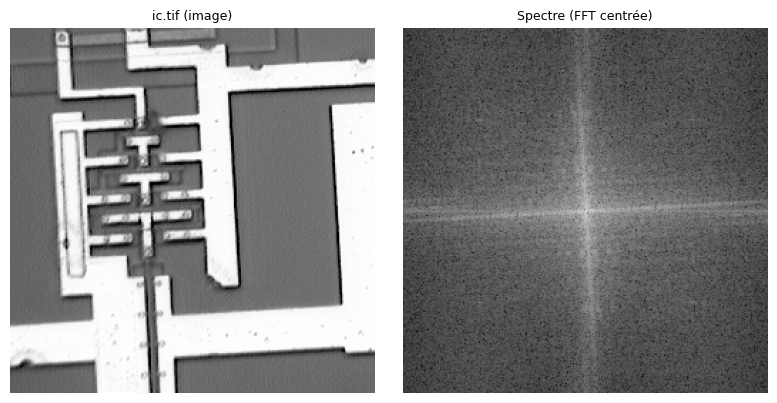

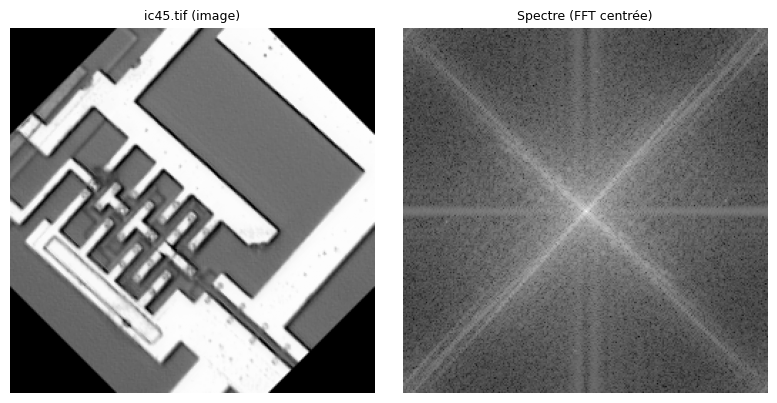

In [50]:
def fft_logmag(gray):
    F = np.fft.fft2(gray)
    Fshift = np.fft.fftshift(F)
    return np.log1p(np.abs(Fshift))

names = ["cameraman.bmp","bureau.gif","testpat1.tif","testpat2.tif","circuit.tif","ic.tif","ic45.tif"]

for name in names:
    g = load_gray(name)
    lm = fft_logmag(g)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(g, cmap="gray")
    axs[0].set_title(f"{name} (image)", fontsize=9)
    axs[0].axis("off")

    axs[1].imshow(lm, cmap="gray")
    axs[1].set_title("Spectre (FFT centrée)", fontsize=9)
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

g = load_gray("cameraman.bmp")
F = np.fft.fft2(g)
dc = F[0,0]
moy = g.mean()
H, W = g.shape


## 3) Masques fréquentiels (low-pass, high-pass, band-pass)

On passe au domaine fréquentiel : on calcule la FFT 2D, on recentre le spectre (`fftshift`), on **applique un masque circulaire** puis on revient dans l’espace image par TF inverse.

- **Low-pass** (`r_out`) : on garde les basses fréquences proches du centre → **lissage / flou**.
- **High-pass** (`r_in`) : on garde les hautes fréquences (loin du centre) → **détails / contours** plus marqués.
- **Band-pass** (`r_in`, `r_out`) : on conserve une **bande de fréquences** → mise en valeur de **textures** à une échelle donnée.

**Implémentation.**  
Masques idéaux (bords nets) dans le plan fréquentiel, produit point à point avec le spectre, puis `ifftshift` + `ifft2`.  
Le choix de `r_in` / `r_out` règle le **seuil fréquentiel** ; l’image de sortie garde la **même taille**.

**Remarque.**  
Des masques idéaux (coupure abrupte) peuvent induire un **ringing** spatial autour des transitions fortes ; on peut l’atténuer avec des masques plus lisses (Butterworth, Gaussien).


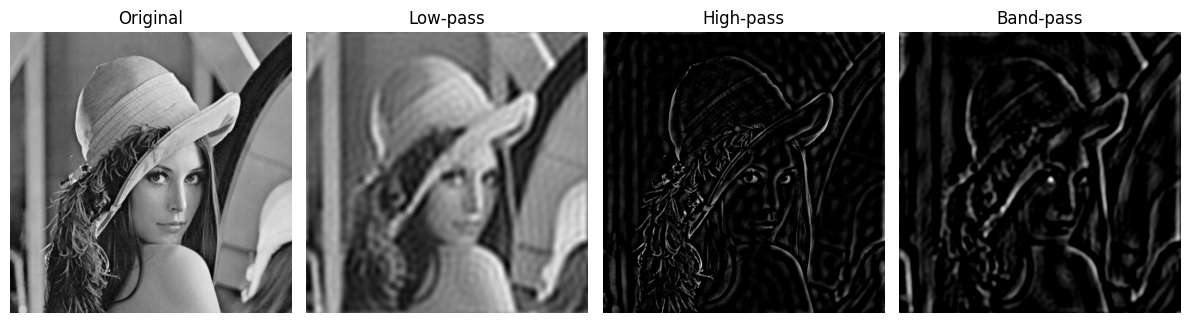

In [51]:
def ideal_mask(shape, kind="low", r_in=10, r_out=30):
    H, W = shape
    Y, X = np.ogrid[:H, :W]
    cy, cx = H//2, W//2
    d2 = (Y-cy)**2 + (X-cx)**2
    if kind=="low":
        return (d2 <= r_out**2).astype(np.float32)
    if kind=="high":
        return (d2 >= r_in**2).astype(np.float32)
    if kind=="band":
        return ((d2 >= r_in**2)&(d2 <= r_out**2)).astype(np.float32)

def freq_filter(img, mask):
    F = np.fft.fft2(img)
    Fshift = np.fft.fftshift(F)
    G = np.fft.ifftshift(Fshift*mask)
    return np.clip(np.real(np.fft.ifft2(G)),0,255).astype(np.uint8)

img = load_gray("lena.bmp")

low  = freq_filter(img, ideal_mask(img.shape,"low",r_out=30))
high = freq_filter(img, ideal_mask(img.shape,"high",r_in=20))
band = freq_filter(img, ideal_mask(img.shape,"band",r_in=10,r_out=40))

fig,axs=plt.subplots(1,4,figsize=(12,4))
for ax,im,title in zip(axs,[img,low,high,band],["Original","Low-pass","High-pass","Band-pass"]):
    ax.imshow(im,cmap="gray"); ax.set_title(title); ax.axis("off")
plt.tight_layout(); plt.show()

## 4) Filtrage spatial (moyenneur 3×3 vs 11×11)

On applique deux noyaux uniformes : **3×3** (lissage léger) et **11×11** (lissage plus fort).

- **Observation.**  
  Le **3×3** adoucit modérément l’image ; le **11×11** atténue davantage les détails et les contours.

- **Netteté.**  
  On s’attend à une baisse plus marquée de la netteté avec **11×11** (la variance du Laplacien diminue davantage qu’avec **3×3**).

- **Taille et bords.**  
  La **taille de sortie** reste la même que l’entrée ; on gère les **bords** par réflexion (`BORDER_REFLECT`) pour limiter les artefacts.

En pratique, on privilégie **3×3** pour un lissage discret, et **11×11** quand on veut lisser plus fortement (au prix de détails perdus).


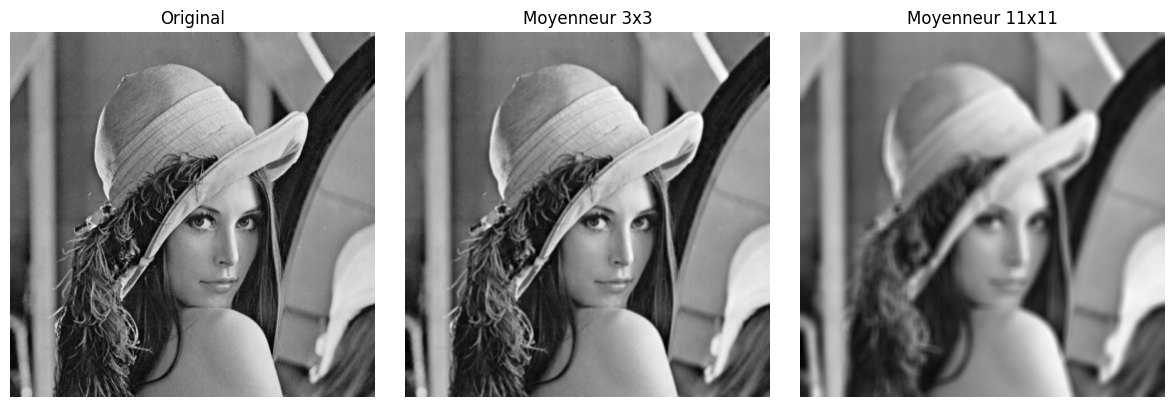

In [52]:
img = load_gray("lena.bmp")

k3  = np.ones((3,3), np.float32) / 9
k11 = np.ones((11,11), np.float32) / 121

f3  = cv2.filter2D(img, -1, k3, borderType=cv2.BORDER_REFLECT)
f11 = cv2.filter2D(img, -1, k11, borderType=cv2.BORDER_REFLECT)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(img, cmap="gray");  axs[0].set_title("Original"); axs[0].axis("off")
axs[1].imshow(f3, cmap="gray");   axs[1].set_title("Moyenneur 3x3"); axs[1].axis("off")
axs[2].imshow(f11, cmap="gray");  axs[2].set_title("Moyenneur 11x11"); axs[2].axis("off")
plt.tight_layout(); plt.show()


## 5) Deux passes 3×3 vs une passe 5×5

On compare un lissage obtenu par **deux passes 3×3** à celui d’**une passe 5×5**.

- **Effet visuel.**  
  Les résultats sont globalement similaires. La différence n’est pas nulle car `(3×3)²` équivaut plutôt à un noyau **5×5 non uniforme** (type binomial), alors que **5×5** est **uniforme**.

- **Coût.**  
  Deux **3×3** sont en général un peu plus légers (~2×9 opérations/px) qu’un **5×5** (~25/px).

- **Bords.**  
  De petits écarts peuvent venir du **padding** et de l’ordre des filtrages.

**Conclusion.**  
On obtient un lissage proche mais pas identique. Selon les contraintes, on privilégie souvent **2×3×3** pour le coût, et **1×5×5** si l’on veut un noyau uniforme en une seule passe.


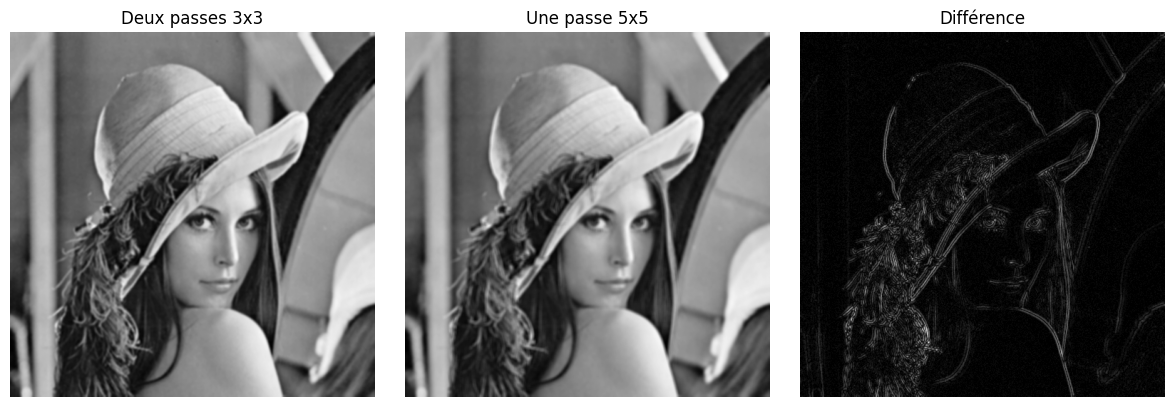

In [53]:
img = load_gray("lena.bmp")

k3 = np.ones((3,3), np.float32) / 9
k5 = np.ones((5,5), np.float32) / 25

twice_3 = cv2.filter2D(cv2.filter2D(img, -1, k3), -1, k3)
once_5  = cv2.filter2D(img, -1, k5)
diff    = cv2.absdiff(twice_3, once_5)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(twice_3, cmap="gray"); axs[0].set_title("Deux passes 3x3"); axs[0].axis("off")
axs[1].imshow(once_5, cmap="gray");  axs[1].set_title("Une passe 5x5");  axs[1].axis("off")
axs[2].imshow(diff, cmap="gray");    axs[2].set_title("Différence");     axs[2].axis("off")
plt.tight_layout(); plt.show()


## 6) Soustraction de l’image moyennée (mise en évidence des hautes fréquences)

On lisse `lena.bmp` par un moyenneur **5×5**, puis on **soustrait** l’image lissée à l’originale :
`sub = image − blur5x5`.  
Cette opération met en évidence les **hautes fréquences** (détails, contours).

- **Soustraction centrée** (`sub + 128`) : on visualise les variations positives/négatives autour d’un gris moyen.
- **Valeur absolue** (`|sub|`) : on obtient une carte d’intensité des détails (indépendante du signe).
- **Binarisation** (`t = 20`) : on produit une carte de **contours** en gardant les variations supérieures au seuil ; `t` règle la sensibilité (plus t est grand, moins il y a de contours).

Cette approche correspond au principe de **unsharp masking** (base) : le flou isole la basse fréquence, la soustraction isole la **partie haute fréquence**. Attention toutefois : on peut aussi **amplifier le bruit** si l’image est très bruitée ou si le seuil est trop bas.


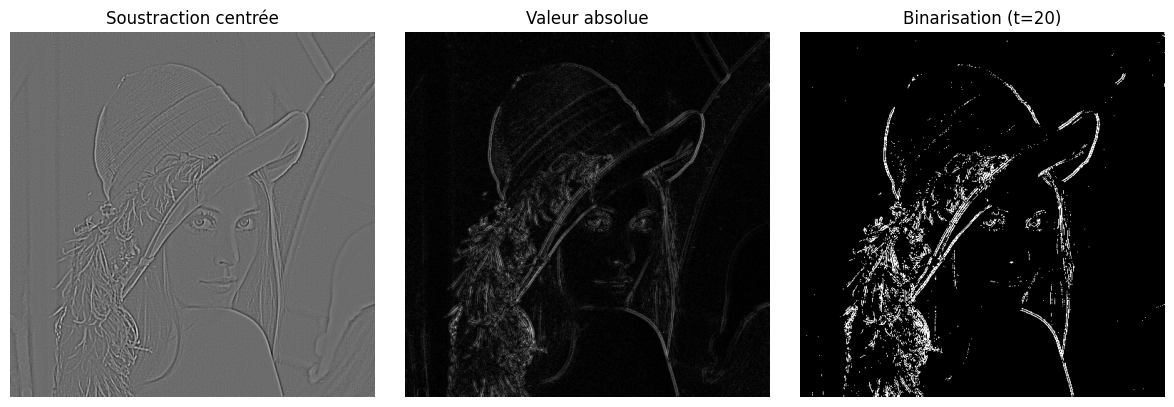

In [54]:
img = load_gray("lena.bmp")
k5 = np.ones((5,5), np.float32) / 25
blur = cv2.filter2D(img, -1, k5)

sub     = img.astype(np.int16) - blur.astype(np.int16)
sub_c   = (sub + 128).clip(0,255).astype(np.uint8)
sub_abs = np.abs(sub).astype(np.uint8)

t = 20
bin_sub = ((sub_abs > t) * 255).astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(sub_c, cmap="gray");   axs[0].set_title("Soustraction centrée"); axs[0].axis("off")
axs[1].imshow(sub_abs, cmap="gray"); axs[1].set_title("Valeur absolue");       axs[1].axis("off")
axs[2].imshow(bin_sub, cmap="gray"); axs[2].set_title(f"Binarisation (t={t})");axs[2].axis("off")
plt.tight_layout(); plt.show()


## 7) Masques 5×5 : effets et combinaisons

On applique les masques **M1**, **M2**, **M3** sur `lena.bmp` et on caractérise leur effet :

- **M1** : **passe-bas (lissage)** : on atténue les hautes fréquences tout en préservant la luminance (somme des coefficients = 1) ; l’image est visuellement plus douce.
- **M2** : **passe-haut / accentuation** : on renforce les transitions, les bords ressortent davantage ; attention aux halos si l’accentuation est trop forte.
- **M3** : **passe-bande (rehaussement local)** : on conserve la basse fréquence centrale et on met en valeur les détails voisins ; les textures gagnent en relief.

On **additionne** ensuite les résultats **M1 + M2 + M3** :  
on obtient un compromis efficace. Le lissage limite le bruit tandis que l’accentuation rehausse les contours.

Enfin, on **soustrait** au moyennage **3×3** le **centième** du filtrage par **M4** (Laplacien) pour un rehaussement léger :  
`Avg3×3 − 0.01 × (M4 * image)`  
→ on redonne un peu de netteté sans sur-amplifier le bruit (le facteur 0.01 dose finement l’effet).


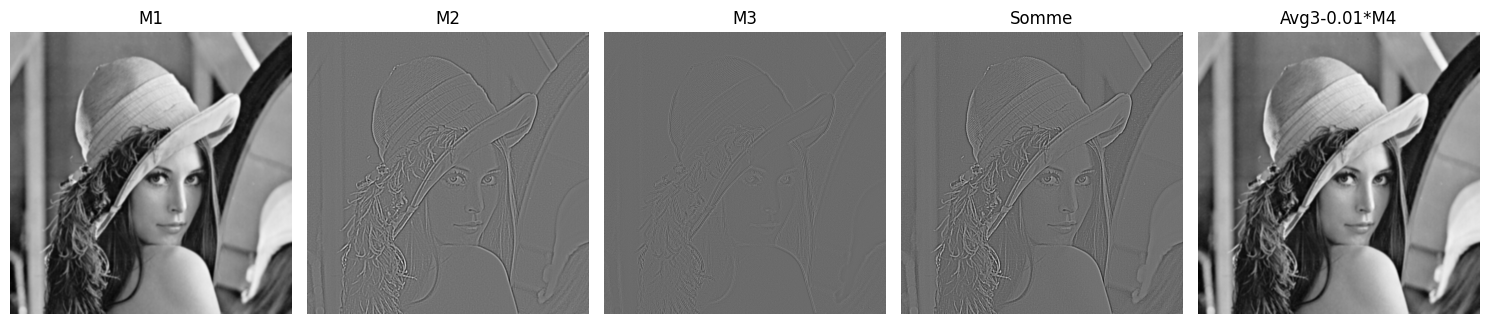

In [60]:
img = load_gray("lena.bmp")

m1 = (1/273)*np.array([
 [ 1,  4,  7,  4, 1],
 [ 4, 16, 26, 16, 4],
 [ 7, 26, 41, 26, 7],
 [ 4, 16, 26, 16, 4],
 [ 1,  4,  7,  4, 1]], np.float32)

m2 = np.array([
 [-0.61, -2.00, -2.85, -2.00, -0.61],
 [-2.00,  1.61,  3.85,  1.61, -2.00],
 [-2.85,  3.85,  8.00,  3.85, -2.85],
 [-2.00,  1.61,  3.85,  1.61, -2.00],
 [-0.61, -2.00, -2.85, -2.00, -0.61]], np.float32)

m3 = np.array([
 [-0.38,  1.00,  1.85,  1.00, -0.38],
 [ 1.00, -2.61, -4.85, -2.61,  1.00],
 [ 1.85, -4.85, 16.00, -4.85,  1.85],
 [ 1.00, -2.61, -4.85, -2.61,  1.00],
 [-0.38,  1.00,  1.85,  1.00, -0.38]], np.float32)

m4 = np.array([
 [-1, -1, -1],
 [-1,  8, -1],
 [-1, -1, -1]], np.float32)

def norm(x): 
    return ((x-x.min())*255/(x.max()-x.min()+1e-6)).astype(np.uint8)

r1,r2,r3 = [cv2.filter2D(img,cv2.CV_32F,m) for m in (m1,m2,m3)]
s123 = r1+r2+r3
avg3 = cv2.filter2D(img,-1,np.ones((3,3),np.float32)/9).astype(np.float32)
combo = avg3 - 0.01*cv2.filter2D(img,cv2.CV_32F,m4)

fig,axs=plt.subplots(1,5,figsize=(15,4))
for ax,im,t in zip(axs,[r1,r2,r3,s123,combo],["M1","M2","M3","Somme","Avg3-0.01*M4"]):
    ax.imshow(norm(im),cmap="gray"); ax.set_title(t); ax.axis("off")
plt.tight_layout(); plt.show()


## 8) Filtres Sobel (masques 5 et 6) sur `carre.png`

- On applique le **masque 5 (Sobel X)** et le **masque 6 (Sobel Y)** à `carre.png`.
- On visualise la **valeur absolue de la somme** : `|Gx + Gy|` (magnitude approximée).
- On **vérifie** que le **masque 5** s’écrit comme la combinaison 1D : `[1 2 1]^T * [-1 0 1]` (Sobel X), en constatant une différence nulle (ou numériquement ~0).
- **Relation entre 5 et 6** : ils approximent les dérivées partielles `∂I/∂x` et `∂I/∂y` sur des directions **orthogonales** (axes x et y).


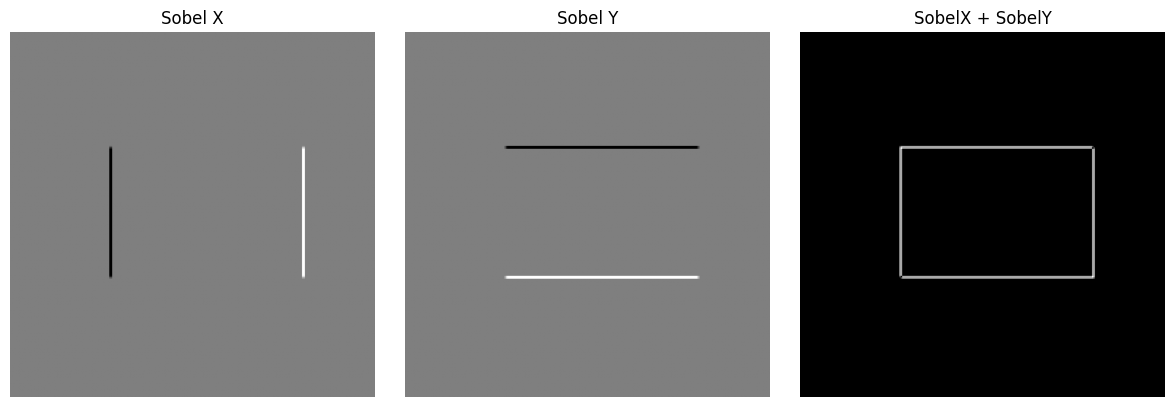

In [61]:
img = load_gray("carre.png")

mask5 = np.array([
 [-1, 0, 1],
 [-2, 0, 2],
 [-1, 0, 1]], np.float32)  

mask6 = np.array([
 [-1, -2, -1],
 [ 0,  0,  0],
 [ 1,  2,  1]], np.float32) 

res5 = cv2.filter2D(img, cv2.CV_32F, mask5)
res6 = cv2.filter2D(img, cv2.CV_32F, mask6)

sum_abs = np.abs(res5 + res6)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(norm(res5), cmap="gray"); axs[0].set_title("Sobel X"); axs[0].axis("off")
axs[1].imshow(norm(res6), cmap="gray"); axs[1].set_title("Sobel Y"); axs[1].axis("off")
axs[2].imshow(norm(sum_abs), cmap="gray"); axs[2].set_title("SobelX + SobelY"); axs[2].axis("off")
plt.tight_layout(); plt.show()

v = np.array([[1],[2],[1]], np.float32)
h = np.array([[-1,0,1]], np.float32)
sobelx_facto = v @ h

 ## 9) Pyramide gaussienne et choix de la taille du filtre

Principe :
À partir de l’image `lena.bmp`, on applique un flou gaussien puis on sous-échantillonne par 2 ; on répète pour obtenir les niveaux 0 → 1 → 2 → 3.

Taille du filtre (en fonction de sigma) :
- Règle pratique : couvrir environ +/- 3 sigma.
- Taille impaire : `ksize ≈ 6*sigma + 1` puis forcer impair (ex. `ksize = int(6*sigma + 1) | 1`).

Remarques :
- Plus `sigma` est grand, plus le noyau doit être large.
- Avec OpenCV, `ksize=0` laisse la taille être déduite de `sigma` ; ici on fixe `ksize` pour la reproductibilité.
- Le sous-échantillonnage est réalisé par un redimensionnement à 1/2 (`INTER_AREA`).


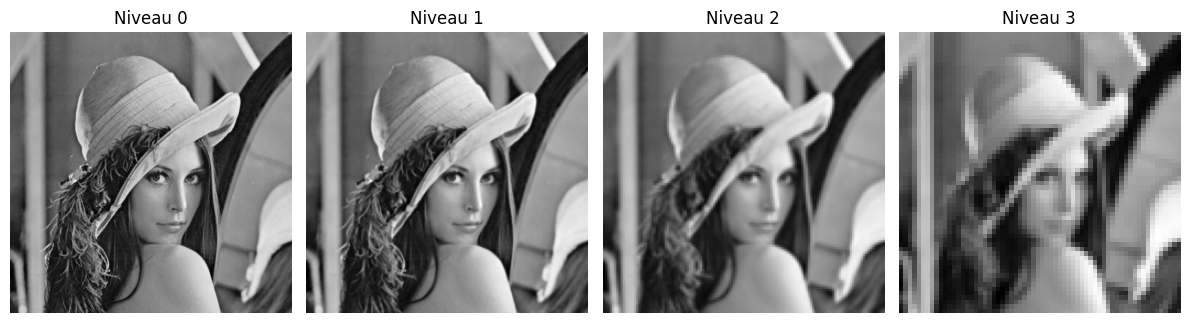

In [64]:
img = load_gray("lena.bmp")

def gaussian_level(gray, sigma=1.0):
    ksize = int(6*sigma + 1) | 1
    g = cv2.GaussianBlur(gray, (ksize, ksize), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REFLECT)
    small = cv2.resize(g, (gray.shape[1]//2, gray.shape[0]//2), interpolation=cv2.INTER_AREA)
    return g, small

g1, p1 = gaussian_level(img, 1.0)
g2, p2 = gaussian_level(p1, 1.0)
g3, p3 = gaussian_level(p2, 1.0)

fig, axs = plt.subplots(1,4,figsize=(12,4))
for ax,im,t in zip(axs,[img,p1,p2,p3],["Niveau 0","Niveau 1","Niveau 2","Niveau 3"]):
    ax.imshow(im,cmap="gray"); ax.set_title(t); ax.axis("off")
plt.tight_layout(); plt.show()


## 10) Ajout de bruit gaussien et calcul du SNR

Nous avons ajouté un bruit gaussien additif à l’image (`cameraman.bmp`) avec une variance normalisée de 0.005 (dans l’échelle [0,1]).  
L’image bruitée est comparée à l’originale et l’écart a été utilisé pour estimer la variance réelle du bruit et le SNR.


**Formule SNR :**  
$$\mathrm{SNR}_{\mathrm{dB}} = 20 \,\log_{10}\!\left(\frac{\sigma_\mathrm{signal}}{\sigma_\mathrm{bruit}}\right)$$

**Observations :**  
- La variance estimée du bruit est proche de la valeur cible (≈ 0.005).  
- Le SNR calculé est cohérent avec la dégradation visuelle : plus la variance du bruit est élevée, plus le SNR diminue.

**Conclusion :**  
- La variance estimée du bruit correspond bien à la valeur théorique imposée.  
- Le SNR fournit une mesure quantitative de la dégradation de l’image liée au bruit.


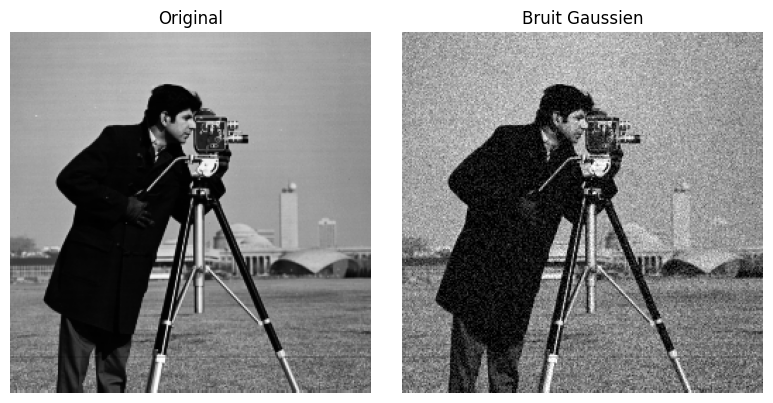

In [65]:
img = load_gray("cameraman.bmp").astype(np.float32)
H, W = img.shape

var_norm = 0.005
noise = np.random.normal(0, math.sqrt(var_norm), size=(H,W)).astype(np.float32)
noisy = np.clip(img + 255*noise, 0, 255).astype(np.uint8)

fig,axs=plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(img.astype(np.uint8),cmap="gray"); axs[0].set_title("Original"); axs[0].axis("off")
axs[1].imshow(noisy,cmap="gray"); axs[1].set_title("Bruit Gaussien"); axs[1].axis("off")
plt.tight_layout(); plt.show()

noise_est = noisy.astype(np.float32) - img
var_est = (noise_est.std()/255)**2
snr = 20*math.log10(img.std()/(noise_est.std()+1e-9))

## 11) Réduction de la variance du bruit par moyennage de plusieurs réalisations

Nous avons généré plusieurs versions bruitées gaussiennes de l’image (`cameraman.bmp`) avec une variance normalisée de 0.005, puis nous avons calculé la moyenne de ces réalisations pour $N=4$ et $N=8$.

**Observations :**  
- Avec une seule réalisation bruitée, la variance du bruit reste élevée.  
- En moyennant $N$ réalisations, la variance résiduelle du bruit diminue.  
- La réduction suit approximativement la loi $1/N$ :  
  - pour $N=4$, la variance est environ divisée par 4 ;  
  - pour $N=8$, la variance est environ divisée par 8.  
- Visuellement, les images moyennées apparaissent beaucoup plus propres.

**Conclusion :**  
Le moyennage de plusieurs images bruitées indépendantes est une méthode efficace pour réduire le bruit : la variance du bruit diminue proportionnellement à $1/N$, confirmant la théorie statistique.


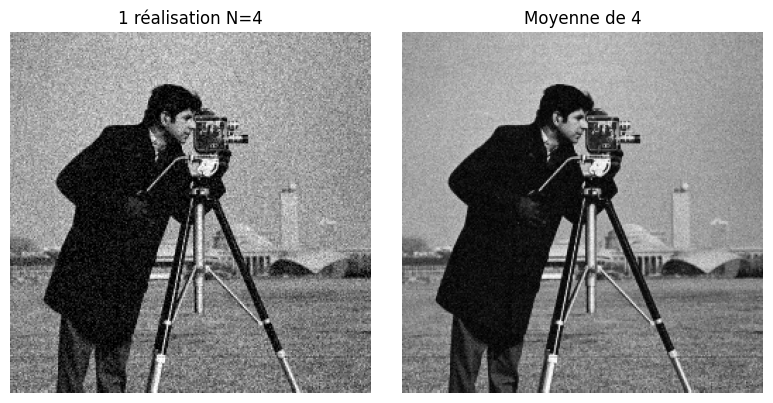

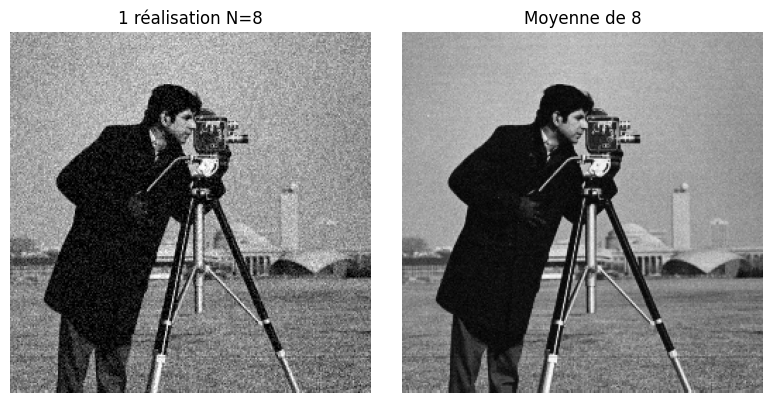

In [66]:
def noisy_gauss(img, var_norm=0.005):
    noise = np.random.normal(0, math.sqrt(var_norm), img.shape).astype(np.float32)
    return np.clip(img.astype(np.float32) + 255*noise, 0, 255).astype(np.uint8)

img = load_gray("cameraman.bmp").astype(np.float32)

for N in (4, 8):
    stack = [noisy_gauss(img) for _ in range(N)]
    mean_img = np.mean(stack, axis=0)

    v_one = np.var(img - stack[0].astype(np.float32))
    v_avg = np.var(img - mean_img)

    fig,axs=plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(stack[0],cmap="gray"); axs[0].set_title(f"1 réalisation N={N}"); axs[0].axis("off")
    axs[1].imshow(mean_img.astype(np.uint8),cmap="gray"); axs[1].set_title(f"Moyenne de {N}"); axs[1].axis("off")
    plt.tight_layout(); plt.show()


## 12) Comparaison du filtre moyenneur et du filtre médian selon le type de bruit

Nous avons ajouté quatre types de bruit à l’image (`cameraman.bmp`) :  
- **Bruit Gaussien** (variance 0.01)  
- **Bruit impulsif (Salt & Pepper)** avec une probabilité de 2%  
- **Bruit speckle** (multiplicatif)  
- **Bruit Poisson**

Chaque image bruitée a ensuite été filtrée avec :  
- un **moyenneur 3×3** (filtre linéaire),  
- un **médian 3×3** (filtre non linéaire).

**Observations :**  
- Pour le **bruit gaussien**, le filtre moyenneur est efficace car il réduit bien le bruit additif.  
  Le filtre médian lisse aussi mais avec un effet légèrement moins adapté.  
- Pour le **bruit impulsif (sel & poivre)**, le filtre médian est nettement supérieur : il supprime les pixels aberrants noirs/blancs tout en préservant les contours.  
- Pour le **bruit speckle**, les deux filtres réduisent un peu le bruit, le moyenneur ayant un léger avantage.  
- Pour le **bruit Poisson**, les deux filtres apportent une amélioration visuelle modeste, sans qu’un filtre soit nettement meilleur que l’autre.

**Conclusion :**  
- Le **moyenneur** convient au bruit gaussien et au bruit speckle.  
- Le **médian** est particulièrement adapté au bruit impulsif.  
- Pour le bruit Poisson, ni le moyenneur ni le médian ne sont parfaitement adaptés, et des méthodes spécialisées seraient plus efficaces.


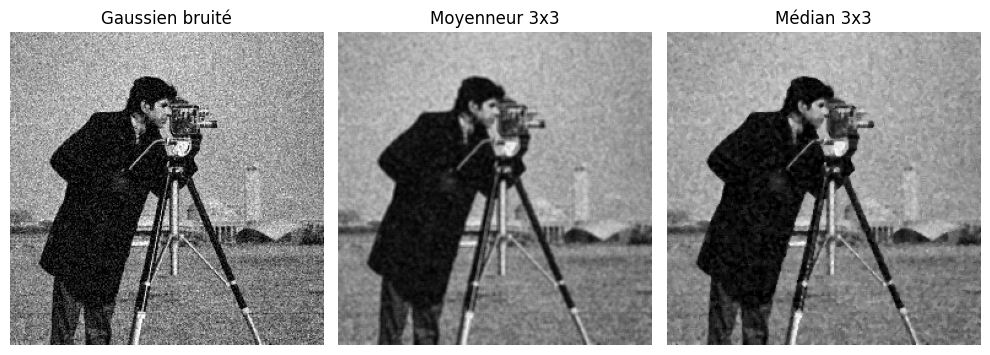

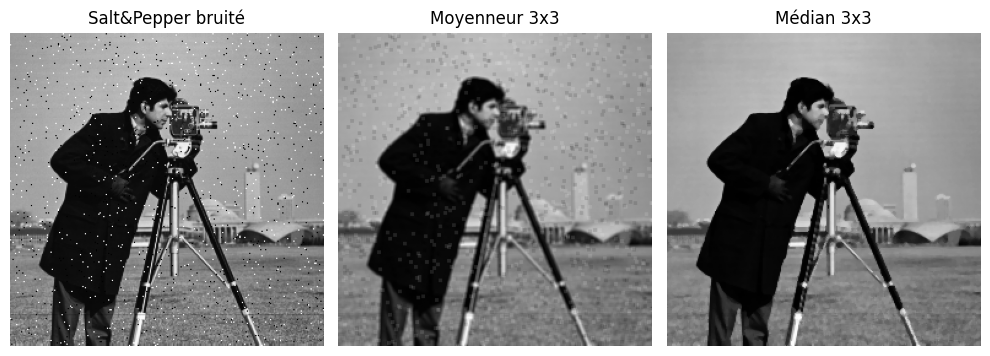

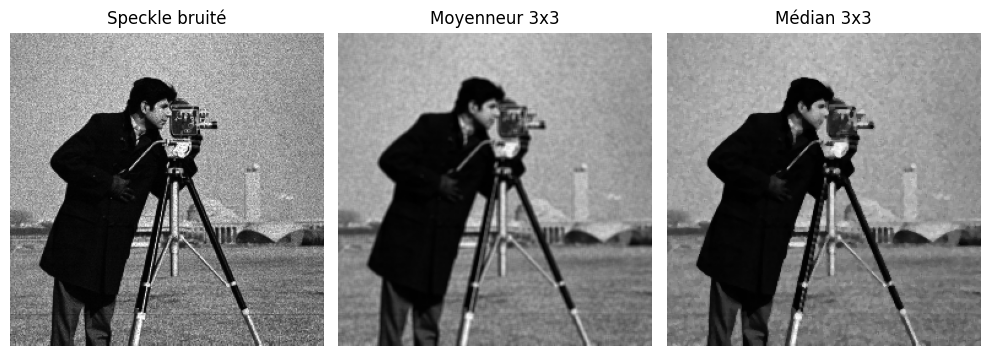

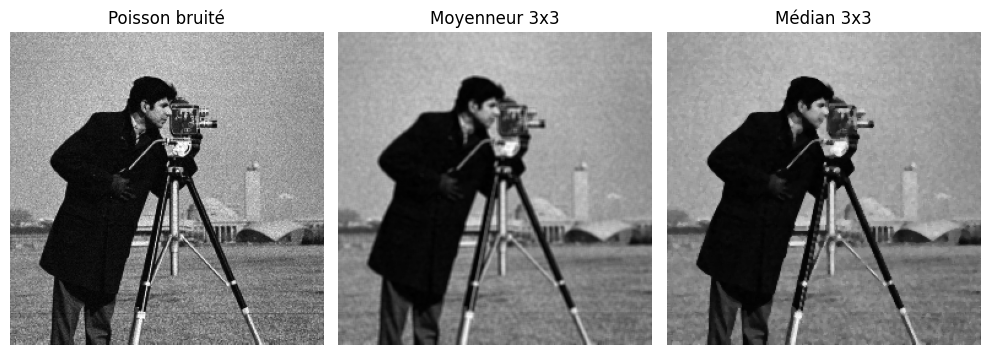

In [67]:
img = load_gray("cameraman.bmp").astype(np.float32)

def noisy_gauss(img, var_norm=0.01):
    noise = np.random.normal(0, math.sqrt(var_norm), img.shape).astype(np.float32)
    return np.clip(img + 255*noise, 0, 255).astype(np.uint8)

def salt_pepper(img, p=0.02):
    out = img.copy().astype(np.uint8)
    n = int(p*out.size)
    coords = np.random.choice(out.size, n, replace=False)
    y, x = np.unravel_index(coords, out.shape)
    half = n//2
    out[y[:half], x[:half]] = 0
    out[y[half:], x[half:]] = 255
    return out

def speckle(img, var_norm=0.01):
    B = np.random.normal(0, math.sqrt(var_norm), img.shape).astype(np.float32)
    return np.clip(img + img*B, 0, 255).astype(np.uint8)

def poisson(img):
    arr = np.clip(img/255.0,0,1)
    return np.clip(np.random.poisson(arr*255)/255*255,0,255).astype(np.uint8)

noises = [
    ("Gaussien", noisy_gauss(img)),
    ("Salt&Pepper", salt_pepper(img)),
    ("Speckle", speckle(img)),
    ("Poisson", poisson(img))
]

mean_filter = lambda im: cv2.filter2D(im, -1, np.ones((3,3),np.float32)/9, borderType=cv2.BORDER_REFLECT)
median_filter = lambda im: cv2.medianBlur(im, 3)

for name, nv in noises:
    f_mean  = mean_filter(nv)
    f_median = median_filter(nv)

    fig,axs=plt.subplots(1,3,figsize=(10,4))
    axs[0].imshow(nv,cmap="gray"); axs[0].set_title(f"{name} bruité"); axs[0].axis("off")
    axs[1].imshow(f_mean,cmap="gray"); axs[1].set_title("Moyenneur 3x3"); axs[1].axis("off")
    axs[2].imshow(f_median,cmap="gray"); axs[2].set_title("Médian 3x3"); axs[2].axis("off")
    plt.tight_layout(); plt.show()


## 13) Comparaison des filtres en fonction du bruit

- **Bruit Gaussien** : le filtre moyenneur 3×3 est bien adapté car il réduit efficacement un bruit additif gaussien.  
  Le filtre médian fonctionne aussi mais est un peu moins performant pour ce type de bruit.

- **Bruit impulsif (Salt & Pepper)** : le filtre médian est nettement supérieur.  
  Il supprime les pixels extrêmes (0 ou 255) sans trop brouiller les contours, alors que le moyenneur laisse des points résiduels.

- **Bruit speckle (multiplicatif)** : les deux filtres atténuent le bruit, mais le moyenneur est en général un peu plus efficace.  
  Toutefois, d’autres méthodes spécifiques (filtrage adaptatif) sont préférables.

- **Bruit Poisson** : les deux filtres apportent une légère amélioration, mais aucun n’est idéal.  
  Dans la pratique, on utiliserait plutôt des méthodes adaptées comme la transformée de variance stabilisante (ex. Anscombe).

**Conclusion :**  
- Le **moyenneur** est adapté au bruit gaussien.  
- Le **médian** est adapté au bruit impulsif.  
- Pour le **speckle** et le **Poisson**, les deux apportent un petit gain mais des filtres spécialisés sont recommandés.
